In [218]:
import numpy as np
from matplotlib import pyplot as plt
import csv
from datetime import datetime

In [219]:
fname = "covid-19-data/us-counties.csv"

In [372]:
csv_reader = csv.DictReader(open(fname))
data = [d for d in csv_reader if d['state'] == 'California']

In [373]:
def entry_to_days(entry):
    d1 = datetime.strptime(entry['date'], "%Y-%m-%d")
    d0 = datetime.strptime("2020-01-01", "%Y-%m-%d")
    return(d1 - d0).days

In [374]:
data[0]

OrderedDict([('date', '2020-01-25'),
             ('county', 'Orange'),
             ('state', 'California'),
             ('fips', '06059'),
             ('cases', '1'),
             ('deaths', '0')])

In [375]:
counties = {}
for d in data:
    l = counties.get(d['county'], [])
    l.append([entry_to_days(d), d['cases']])
    counties[d['county']] = l

In [376]:
len(counties)

55

In [377]:
def trajectory(county, window=5):
    raw = sorted(counties[county], key = lambda e: e[0])
    rates = [(float(raw[i][1]) - float(raw[i-window][1])) / (raw[i][0] - raw[i-window][0])
             for i in range(window, len(raw))]
    cums = [float(r[1]) for r in raw[window:]]
    indices = [i for i in range(len(cums)) if cums[i] > 1 and rates[i] > 1]
    return [[cums[i] for i in indices], [rates[i] for i in indices]]

In [378]:
def plot_traj(county, color, window=5):
    data = trajectory(county, window=window)
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel('average new cases per day')
    plt.xlabel('cumulative cases')
    plt.plot(data[0], data[1], color, label=county)

In [379]:
class ColorPicker:
    def __init__(self):
        self.colors = [c + "-" for c in "kbrgcm"] + [c + "--" for c in "kbrgcm"]
        self.i = 0
    def get(self):
        c = self.colors[self.i]
        self.i += 1
        self.i = self.i % len(self.colors)
        return c




Orange : 2198.0
Los Angeles : 20976.0
Santa Clara : 2122.0
San Francisco : 1471.0
San Diego : 3378.0
Sacramento : 1053.0
Alameda : 1554.0
San Mateo : 1099.0
Contra Costa : 843.0
Riverside : 3735.0
San Bernardino : 1827.0
Kern : 865.0


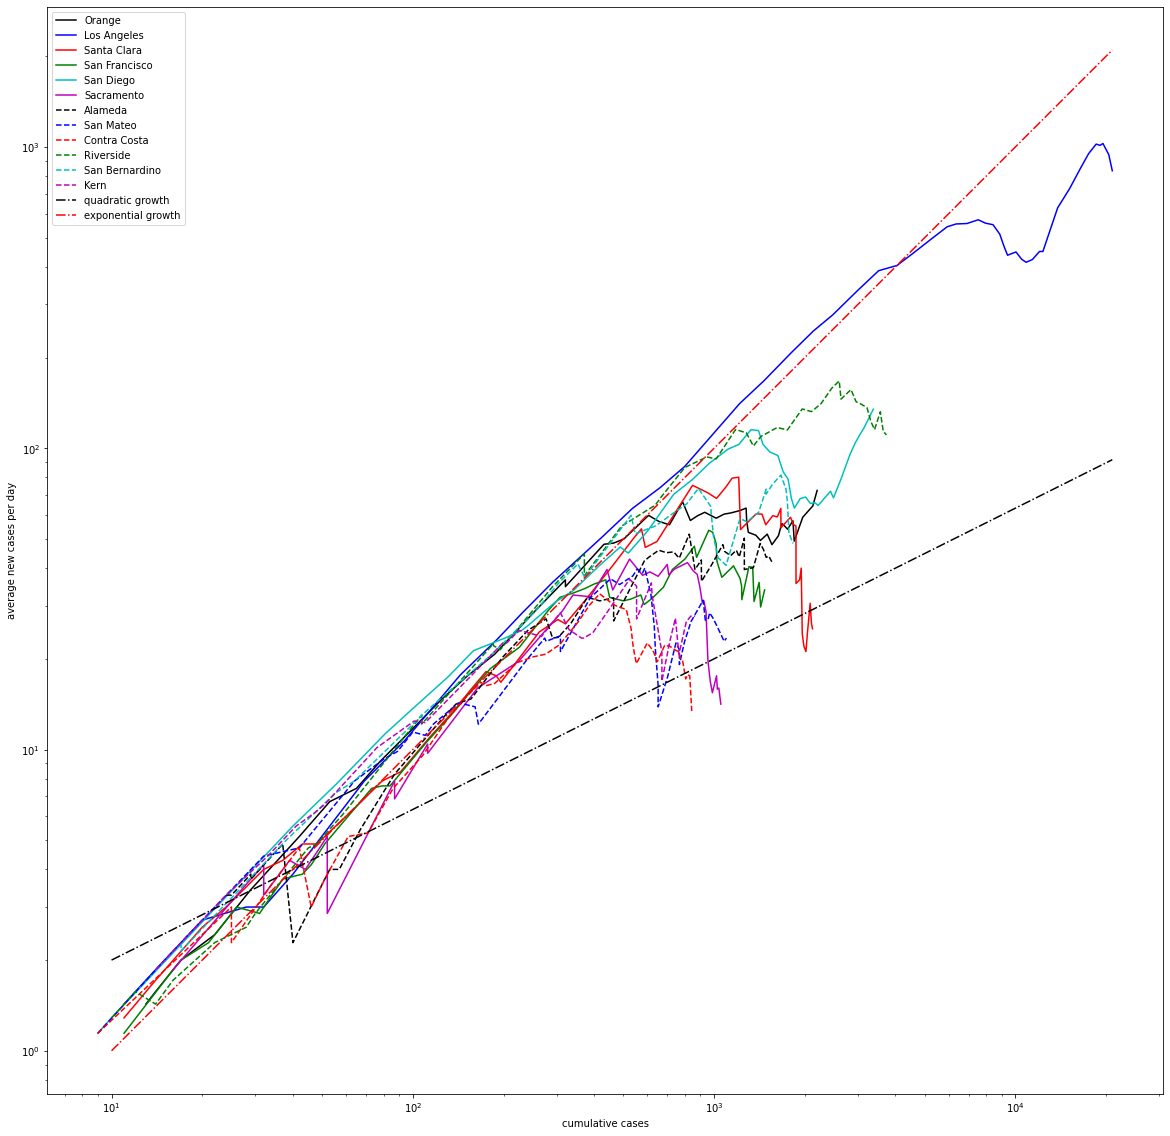

In [394]:
col_pick = ColorPicker()
plt.rcParams['figure.figsize'] = [20,20]
plt.axes().set_aspect('equal', 'datalim')
maxpt = 0.0
for county in counties.keys():
    t = trajectory(county)
    if len(t[0]) < 1:
        continue
    if t[0][-1] < 800:
        continue
    if county == 'Unknown':
        continue
    plot_traj(county, col_pick.get(), window=7)
    print(county + " : " + str(t[0][-1]))
    maxpt = max(maxpt, t[0][-1])
plt.plot([10.0, maxpt], [2.0, 2.0 * np.sqrt(0.1 * maxpt)], 'k-.', label="quadratic growth")
plt.plot([10.0, maxpt], [1.0, 0.1 * maxpt], 'r-.', label="exponential growth")
plt.legend()